<a href="https://colab.research.google.com/github/IvanLubimyy/PyTorch_CNN/blob/master/PyTorch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [0]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2019-05-01 16:20:18--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  26.6MB/s    in 8.6s    

2019-05-01 16:20:27 (20.3 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2019-05-01 16:20:27--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  23.7MB/s    in 2.6s    

2019-05-01 16:20:30 (23.7 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2019-05-01 16:20:30--
Total wall clock time: 12s
Downloaded: 2 files, 235M in

In [0]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [0]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [0]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [0]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [0]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [0]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10)
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [0]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs,scheduler=None,annel_k=0.2, annel_epoch=1000):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        #torch.optim.scheduler.step()
        if epoch % annel_epoch == 0 :
          for g in optimizer.param_groups:
            g['lr'] = g['lr']*annel_k
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            if scheduler is not None:
              scheduler.step
            else:
              optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
    #print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
            
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
      x_gpu = x.to(device)
      y_gpu = y.to(device)
      pred = model(x_gpu)
      
      _, indices = torch.max(pred, 1)
      correct_samples += torch.sum(indices == y_gpu)
      total_samples += y.shape[0]
 
    accuracy = float(correct_samples) / total_samples
    
    return accuracy
  
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.075923, Train accuracy: 0.274204, Val accuracy: 0.434783
Average loss: 1.353458, Train accuracy: 0.562946, Val accuracy: 0.657703
Average loss: 0.933033, Train accuracy: 0.716172, Val accuracy: 0.727732
Average loss: 0.754563, Train accuracy: 0.775501, Val accuracy: 0.759675
Average loss: 0.664802, Train accuracy: 0.805754, Val accuracy: 0.797761


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [0]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR)
])
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.43,0.44,0.47],
#                       std=[0.20,0.20,0.20])                           

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

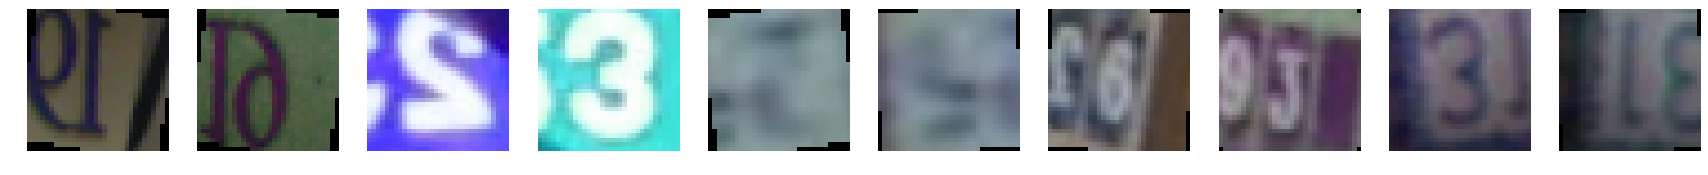

In [0]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

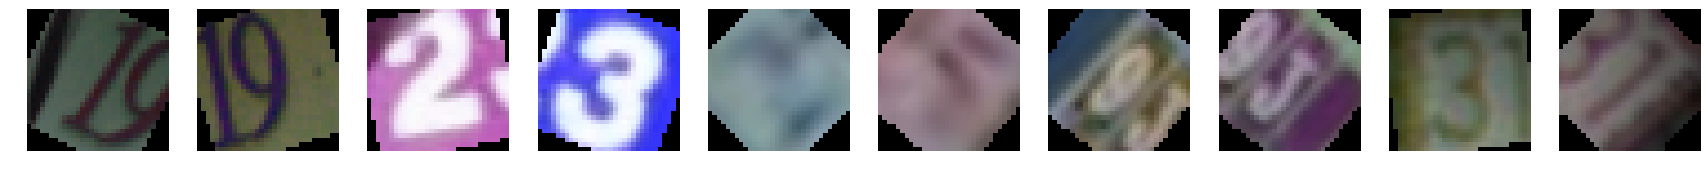

In [0]:
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR)
   # transforms.ToTensor()
  #  transforms.Normalize(mean=[0.43,0.44,0.47],
   #                    std=[0.20,0.20,0.20])                           
])
data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')
    
# TODO create new instances of loaders with the augmentations you chose
train_aug_loader = None

In [0]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.817876, Train accuracy: 0.741460, Val accuracy: 0.738653
Average loss: 0.819270, Train accuracy: 0.739259, Val accuracy: 0.738653
Average loss: 0.824620, Train accuracy: 0.738730, Val accuracy: 0.738653
Average loss: 0.821014, Train accuracy: 0.740675, Val accuracy: 0.738653
Average loss: 0.819647, Train accuracy: 0.739139, Val accuracy: 0.738653


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [0]:
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                        std=[0.20,0.20,0.20])                           
])
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )
train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

In [0]:
# TODO: Implement LeNet-like architecture for SVHN task
''''  Input - 3x32x32
    C1 - 6@28x28 (5x5 kernel)
    tanh
    S2 - 6@14x14 (2x2 kernel, stride 2) Subsampling
    C3 - 16@10x10 (5x5 kernel, complicated shit)
    tanh
    S4 - 16@5x5 (2x2 kernel, stride 2) Subsampling
    C5 - 120@1x1 (5x5 kernel)
    F6 - 84
    tanh
    F7 - 10 (Output) '''
lenet_model = nn.Sequential(
             nn.Conv2d(3, 6, kernel_size=(5, 5)),
             nn.ReLU(),
             nn.MaxPool2d(kernel_size=(2, 2), stride=2),
             nn.Conv2d(6, 16, kernel_size=(5, 5)),
             nn.ReLU(),
             nn.MaxPool2d(kernel_size=(2, 2), stride=2),
             Flattener(),
             nn.Linear(16*5*5, 120), 
             nn.ReLU(), 
             nn.Linear(120, 84),
             nn.ReLU(),
             nn.Linear(84, 10),
             nn.LogSoftmax(dim=-1)
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [0]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.754423, Train accuracy: 0.392929, Val accuracy: 0.711078
Average loss: 0.824078, Train accuracy: 0.745248, Val accuracy: 0.775920
Average loss: 0.679137, Train accuracy: 0.791984, Val accuracy: 0.786704
Average loss: 0.612637, Train accuracy: 0.812698, Val accuracy: 0.825063
Average loss: 0.575621, Train accuracy: 0.823875, Val accuracy: 0.825473
Average loss: 0.541423, Train accuracy: 0.834642, Val accuracy: 0.835984
Average loss: 0.525339, Train accuracy: 0.839044, Val accuracy: 0.843560
Average loss: 0.510256, Train accuracy: 0.844538, Val accuracy: 0.838100
Average loss: 0.490716, Train accuracy: 0.851380, Val accuracy: 0.838168
Average loss: 0.480394, Train accuracy: 0.852984, Val accuracy: 0.848406


# Подбор гиперпараметров

In [0]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well
%%time
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epoch', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [  1e-4, 1, 1e-1, 1e-2, 1e-3]
anneal_coeff = 0.2
anneal_epochs = [1, 5, 10]
regs = [1e-3, 1e-4, 1e-5, 1e-7]

batch_size = 64
epoch_num = 10

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!
for i1 in range(len(learning_rates)):
  for i2 in range(len(anneal_epochs)):
    for i3 in range(len(regs)):
    
      le, an, r = learning_rates[i1], anneal_epochs[i2], regs[i3]
      name_hyp="Lr:"+str(learning_rates[i1])+", Anneal_epochs:"+str(anneal_epochs[i2])+", Reg str:"+str(regs[i3])
      
      optimizer = optim.SGD(lenet_model.parameters(), lr=le, weight_decay=r)
      
      #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=an, gamma=anneal_coeff)
      print("Hyperparams: %s" % (name_hyp))
      _, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10, annel_k=anneal_coeff, annel_epoch=an)
      print("--------")
      run_record[name_hyp]=RunResult("lenet_model", train_history, val_history, val_history[-1])
     
      # TODO: Your code here!

NameError: ignored

In [0]:
  my_model = nn.Sequential(    
             nn.Conv2d(3, 6, kernel_size=(5, 5)),
                    
             nn.ReLU(),
             nn.MaxPool2d(kernel_size=(2, 2), stride=2),
             nn.Conv2d(6, 16, kernel_size=(5, 5)),
                   
             nn.ReLU(),
             nn.MaxPool2d(kernel_size=(2, 2), stride=2),
             Flattener(),
             nn.Linear(16*5*5, 120), 
             nn.BatchNorm1d(120),
             nn.ReLU(), 
             nn.Linear(120, 84),
             nn.BatchNorm1d(84),
             nn.ReLU(),
             nn.Linear(84, 10),
             nn.LogSoftmax(dim=-1)
  )
my_model.type(torch.cuda.FloatTensor)
my_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
  

In [0]:
%%time
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epoch', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [ 1e-1]
anneal_coeff = 0.2
anneal_epochs = [ 5]
regs = [1e-3]

batch_size = 64
epoch_num = 30

run_record_my = {} 

for i1 in range(len(learning_rates)):
  for i2 in range(len(anneal_epochs)):
    for i3 in range(len(regs)):
    
      le, an, r = learning_rates[i1], anneal_epochs[i2], regs[i3]
      name_hyp="Lr:"+str(learning_rates[i1])+", Anneal_epochs:"+str(anneal_epochs[i2])+", Reg str:"+str(regs[i3])
      
      optimizer = optim.SGD(my_model.parameters(), lr=le, weight_decay=r)
      
      #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=an, gamma=anneal_coeff)
      print("Hyperparams: %s" % (name_hyp))
      _, train_history, val_history = train_model(my_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, annel_k=anneal_coeff, annel_epoch=an)
      print("--------")
      run_record_my[name_hyp]=RunResult("my_model", train_history, val_history, val_history[-1])
     

Hyperparams: Lr:0.1, Anneal_epochs:5, Reg str:0.001
Average loss: 0.693762, Train accuracy: 0.782241, Val accuracy: 0.809228
Average loss: 0.623646, Train accuracy: 0.805156, Val accuracy: 0.817350
Average loss: 0.585554, Train accuracy: 0.816776, Val accuracy: 0.837622
Average loss: 0.561600, Train accuracy: 0.824472, Val accuracy: 0.840557
Average loss: 0.541667, Train accuracy: 0.831468, Val accuracy: 0.848406
Average loss: 0.487635, Train accuracy: 0.850869, Val accuracy: 0.863832
Average loss: 0.473641, Train accuracy: 0.853786, Val accuracy: 0.870180
Average loss: 0.467004, Train accuracy: 0.856687, Val accuracy: 0.869838
Average loss: 0.462883, Train accuracy: 0.858308, Val accuracy: 0.869019
Average loss: 0.454099, Train accuracy: 0.860390, Val accuracy: 0.873251
Average loss: 0.444888, Train accuracy: 0.863546, Val accuracy: 0.875503
Average loss: 0.445809, Train accuracy: 0.863581, Val accuracy: 0.876118
Average loss: 0.440813, Train accuracy: 0.864553, Val accuracy: 0.874343

In [0]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.6f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.900689, best hyperparams: Lr:0.01, Anneal_epochs:10, Reg str:0.0001


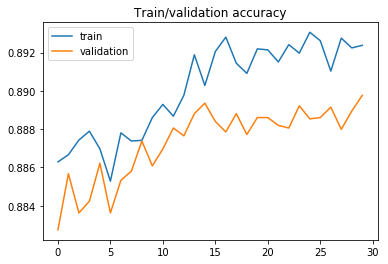

In [0]:
plt.title("Train/validation accuracy")
plt.plot(train_history, label="train")
plt.plot(val_history, label="validation")
plt.legend()

# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [0]:
my_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(128*2*2, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Linear(256, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=-1)
          )

my_model.type(torch.cuda.FloatTensor)
my_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)

In [0]:
%%time
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epoch', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [ 1e-1, 1e-2]
anneal_coeff = 0.1
anneal_epochs = [5]
regs = [ 1e-3, 1e-4]

batch_size = 64
epoch_num = 20

run_record_my = {} 

for i1 in range(len(learning_rates)):
  for i2 in range(len(anneal_epochs)):
    for i3 in range(len(regs)):
    
      le, an, r = learning_rates[i1], anneal_epochs[i2], regs[i3]
      name_hyp="Lr:"+str(learning_rates[i1])+", Anneal_epochs:"+str(anneal_epochs[i2])+", Reg str:"+str(regs[i3])
      
      optimizer = optim.SGD(my_model.parameters(), lr=le, weight_decay=r)
      
      #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=an, gamma=anneal_coeff)
      print("Hyperparams: %s" % (name_hyp))
      _, train_history, val_history = train_model(my_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, annel_k=anneal_coeff, annel_epoch=an)
      print("--------")
      run_record_my[name_hyp]=RunResult("my_model", train_history, val_history, val_history[-1])
     

Hyperparams: Lr:0.1, Anneal_epochs:5, Reg str:0.001
Average loss: 0.694766, Train accuracy: 0.780278, Val accuracy: 0.726162
Average loss: 0.676681, Train accuracy: 0.784612, Val accuracy: 0.771961
Average loss: 0.659808, Train accuracy: 0.788435, Val accuracy: 0.795782
Average loss: 0.651085, Train accuracy: 0.794151, Val accuracy: 0.781380
Average loss: 0.641753, Train accuracy: 0.796813, Val accuracy: 0.776602
Average loss: 0.585603, Train accuracy: 0.815138, Val accuracy: 0.823630


In [0]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record_my.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.6f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.889769, best hyperparams: Lr:0.1, Anneal_epochs:10, Reg str:1e-05


In [0]:
best_model = my_model

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [0]:
train_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, 
                                           sampler=train_sampler)

In [0]:
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                        std=[0.20,0.20,0.20])
                        ])
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

In [0]:
optimizer = optim.SGD(my_model.parameters(), lr=0.01, weight_decay=1e-05)      
_, train_history, val_history = train_model(my_model, train_aug_loader, val_loader, loss, optimizer, 30)

Average loss: 0.350281, Train accuracy: 0.891735, Val accuracy: 0.889018
Average loss: 0.349221, Train accuracy: 0.890660, Val accuracy: 0.888267
Average loss: 0.347792, Train accuracy: 0.892025, Val accuracy: 0.887038
Average loss: 0.350111, Train accuracy: 0.890796, Val accuracy: 0.887175
Average loss: 0.348898, Train accuracy: 0.891052, Val accuracy: 0.889496
Average loss: 0.346053, Train accuracy: 0.891530, Val accuracy: 0.889427
Average loss: 0.346890, Train accuracy: 0.892212, Val accuracy: 0.887584
Average loss: 0.349034, Train accuracy: 0.891956, Val accuracy: 0.889427
Average loss: 0.346305, Train accuracy: 0.891769, Val accuracy: 0.888267
Average loss: 0.349126, Train accuracy: 0.891718, Val accuracy: 0.885264
Average loss: 0.346920, Train accuracy: 0.891837, Val accuracy: 0.888950
Average loss: 0.345929, Train accuracy: 0.893236, Val accuracy: 0.888608
Average loss: 0.347058, Train accuracy: 0.893919, Val accuracy: 0.888881
Average loss: 0.345387, Train accuracy: 0.892861, V

In [0]:
# TODO Write the code to compute accuracy on test set
final_test_accuracy = compute_accuracy(best_model, train_loader)
print("Final test accuracy - ", final_test_accuracy)

NameError: ignored